In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [8]:
print(matplotlib.__version__)

NameError: name 'sklearn' is not defined

In [2]:
# Load dataset
df = pd.read_csv('dataperokok.csv')
df_penduduk = pd.read_csv('Jumlah_Penduduk.csv')


In [3]:
df.head()

,38 Provinsi,2019,2020,2021,2022,2023
0,ACEH,28.70,28.06,28.30,27.58,28.66
1,SUMATERA UTARA,27.46,27.28,27.24,25.32,26.28
2,SUMATERA BARAT,30.75,30.08,30.50,30.27,30.42
3,RIAU,29.04,28.06,28.34,26.86,27.76
4,JAMBI,28.54,28.01,27.47,28.62,28.67


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   38 Provinsi  34 non-null     object 
 1   2019         34 non-null     float64
 2   2020         34 non-null     float64
 3   2021         34 non-null     float64
 4   2022         34 non-null     float64
 5   2023         34 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.7+ KB


In [5]:
df.isnull().any()

38 Provinsi    False
2019           False
2020           False
2021           False
2022           False
2023           False
dtype: bool

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


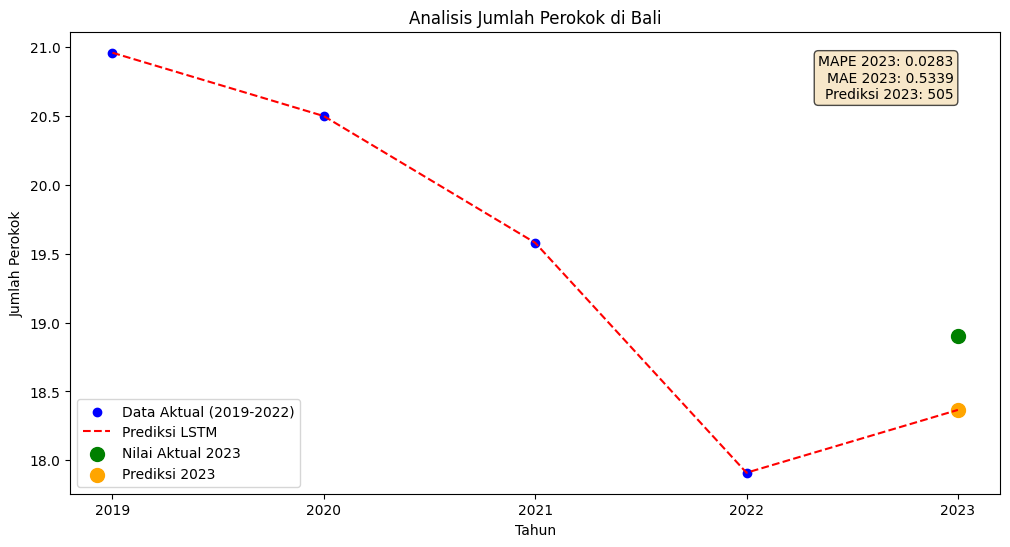

MAPE 2023: 0.0283
MAE 2023: 0.5339
Prediksi 2023: 505
Nilai Aktual 2023: 18.90


In [6]:
# Set seed untuk memastikan hasil yang konsisten
np.random.seed(42)
tf.random.set_seed(42)

def build_lstm_model(input_shape, units=50):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def analisis_provinsi_lstm(nama_provinsi, units=50, batch_size=8, epochs=50):
    # Filter data berdasarkan nama provinsi
    data_provinsi = df[df['38 Provinsi'].str.lower() == nama_provinsi.lower()].iloc[0]
    data_penduduk = df_penduduk[df_penduduk['38 Provinsi'].str.lower() == nama_provinsi.lower()].iloc[0]

    # Simpan nama provinsi dalam format judul (capitalized)
    nama_provinsi_cap = data_provinsi['38 Provinsi'].title()

    # Persiapkan data untuk model LSTM
    jumlah_perokok = data_provinsi[['2019', '2020', '2021', '2022']].values.reshape(-1, 1)

    # Normalisasi data menggunakan Min-Max Scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    jumlah_perokok_scaled = scaler.fit_transform(jumlah_perokok)

    # Membentuk data pelatihan dengan bentuk (samples, timesteps, features)
    X_train = []
    y_train = []
    for i in range(1, len(jumlah_perokok_scaled)):
        X_train.append(jumlah_perokok_scaled[i-1:i].reshape(1, -1))  # Menggunakan data sebelumnya sebagai fitur
        y_train.append(jumlah_perokok_scaled[i])  # Menggunakan data sekarang sebagai target
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Pastikan bentuk X_train adalah (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[2]))

    # Membuat dan melatih model LSTM
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), units=units)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Prediksi untuk tahun 2023
    last_scaled = jumlah_perokok_scaled[-1].reshape(1, 1, 1)  # Gunakan data terakhir (2022) untuk memprediksi 2023
    prediksi_2023_scaled = model.predict(last_scaled)
    prediksi_2023 = scaler.inverse_transform(prediksi_2023_scaled).reshape(-1, 1)

    # Kalikan prediksi dengan jumlah penduduk untuk mendapatkan jumlah aktual
    jumlah_penduduk_2023 = data_penduduk['2023']  # Sesuaikan skala data penduduk jika perlu
    prediksi_2023_jumlah = prediksi_2023[0][0] / 100 * jumlah_penduduk_2023 

    # Evaluasi menggunakan data aktual tahun 2023
    y_true_2023 = np.array([[data_provinsi['2023']]])

    # Hitung MAPE dan MAE
    mape_2023 = mean_absolute_percentage_error(y_true_2023, prediksi_2023)
    mae_2023 = mean_absolute_error(y_true_2023, prediksi_2023)

    # Visualisasi hasil
    tahun_plot = np.array([2019, 2020, 2021, 2022, 2023])
    jumlah_perokok_plot = np.append(jumlah_perokok, prediksi_2023, axis=0)

    plt.figure(figsize=(12, 6))
    plt.scatter(tahun_plot[:-1], jumlah_perokok, color='blue', label='Data Aktual (2019-2022)')
    plt.plot(tahun_plot, jumlah_perokok_plot, color='red', linestyle='--', label='Prediksi LSTM')
    
    plt.scatter(2023, y_true_2023, color='green', s=100, label='Nilai Aktual 2023')
    plt.scatter(2023, prediksi_2023, color='orange', s=100, label='Prediksi 2023')

    plt.title(f'Analisis Jumlah Perokok di {nama_provinsi_cap}')
    plt.xlabel('Tahun')
    plt.ylabel('Jumlah Perokok')
    
    plt.xticks(tahun_plot)  # Menampilkan hanya tahun 2019, 2020, 2021, 2022, 2023
    plt.legend()

    # Tambahkan informasi MAPE, MAE, dan prediksi di sudut kanan atas dalam area plot
    info_text = f'MAPE 2023: {mape_2023:.4f}\nMAE 2023: {mae_2023:.4f}\nPrediksi 2023: {prediksi_2023_jumlah:.0f}'
    plt.text(0.95, 0.95, info_text, transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    plt.show()

    return {
        'provinsi': nama_provinsi_cap,
        'mape_2023': mape_2023,
        'mae_2023': mae_2023,
        'prediksi_2023': prediksi_2023[0][0],
        'prediksi_2023_jumlah': prediksi_2023_jumlah,
        'y_true_2023': y_true_2023[0][0],
        'plot': plt
    }

# Contoh penggunaan dengan pengaturan default:
hasil = analisis_provinsi_lstm('Bali')
hasil['plot'].show()

print(f"MAPE 2023: {hasil['mape_2023']:.4f}")
print(f"MAE 2023: {hasil['mae_2023']:.4f}")
print(f"Prediksi 2023: {hasil['prediksi_2023_jumlah']:.0f}")
print(f"Nilai Aktual 2023: {hasil['y_true_2023']:.2f}")
